In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import requests
import os
import numpy as np

import torch
from torchvision import models
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax
from torch.optim import Adam,lr_scheduler
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset

from utils_d import *

device = torch.device("cuda:0")

import sys
sys.path.append(r'E:\codes\python\area51m\pytorch_deeplab_xception')
from pytorch_deeplab_xception.modeling import deeplab

import os
os.environ['TORCH_HOME'] = r'E:\data\MODELS' 

In [2]:
num_c = 8

dl = deeplab.DeepLab(num_classes=num_c,backbone = 'xception',output_stride = 16).to(device)

for name, param in dl.named_parameters():                
    if name.startswith('backbone'):
        param.requires_grad = False

In [3]:
image_size = (900,900)

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ColorJitter(brightness = 0.15,
                                                       saturation = 0.1,
                                                       hue = 0.01,
                                                       contrast = 0.15),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [4]:
data = pd.read_csv(r'E:\UCL\Dissertation\label\lb_2.csv')

dataset_train = Segdata(transform,image_size,
                        r'lb_2.csv',r'E:\UCL\Dissertation\label',['input','download'])

dataset_test = Segdata(transform,image_size,
                       r'lb_test.csv',r'E:\UCL\Dissertation\label',['input_test','download_test'])

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=6, 
                                         shuffle=True, num_workers=0,drop_last  = True)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, num_workers=0,drop_last  = False)

In [5]:
freq = 1/get_frequency(data,image_size,num_c,r'E:\UCL\Dissertation\label','download')

#freq_norm = torch.full((num_c,1),1/num_c).to(device)

In [6]:
plist = [
         {'params': dl.parameters(),'lr':1e-2}
         ]

#criterion = CrossEntropyLoss(ignore_index = 0,weight = freq/freq.sum())
criterion = CrossEntropyLoss(ignore_index = 0,weight = torch.log(freq)/torch.log(freq).sum())
#criterion = CrossEntropyLoss(ignore_index = 0)

optimizer = Adam(params=plist)
        
scheduler = lr_scheduler.StepLR(optimizer, step_size=50,gamma=0.1)

loss_list_train = []

loss_list_test = []

best_val_loss = float('inf')

n_epoch = 100

In [7]:
for epoch in range(n_epoch):
    training_loss,training_iou = train(dl,dataloader_train,optimizer,criterion,loss_list_train,num_c)
    val_loss,val_iou = evaluate(dl,dataloader_test,criterion,loss_list_test,num_c)
    scheduler.step()
    print('finished {0}th training'.format(epoch+1))
    print('training loss: {0}, training iou: {1}'.format(training_loss.item(),training_iou))
    print('validation loss: {0}, validation iou: {1}'.format(val_loss.item(),val_iou))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(dl.state_dict(), r'E:\UCL\Dissertation\label\trained_models\model_deeplabv3+_xception_best.pt')

finished 1th training
training loss: 1.4605091373125711, training iou: 0.1903391508378154
validation loss: 6.12741032242775, validation iou: 0.24161099822266602
finished 2th training
training loss: 0.7544103542963664, training iou: 0.2666204485456272
validation loss: 10.695378389954566, validation iou: 0.26329965836573027
finished 3th training
training loss: 0.6808920423189799, training iou: 0.30726286429148303
validation loss: 9.767206099629401, validation iou: 0.2879768629043402
finished 4th training
training loss: 0.624762103954951, training iou: 0.31297707257836055
validation loss: 9.23909844905138, validation iou: 0.30917177980967786
finished 5th training
training loss: 0.5727751990159352, training iou: 0.32783065910371517
validation loss: 6.479605078697205, validation iou: 0.2900688430626431
finished 6th training
training loss: 0.4911661525567373, training iou: 0.3364535562197079
validation loss: 1.3301705319434405, validation iou: 0.34332573924919335
finished 7th training
traini

finished 52th training
training loss: 0.22331025103727978, training iou: 0.4538922411295817
validation loss: 0.394605265930295, validation iou: 0.4497285107459249
finished 53th training
training loss: 0.20899334748586018, training iou: 0.46370912254310653
validation loss: 0.4312158450484276, validation iou: 0.4610177936008064
finished 54th training
training loss: 0.20493190685908, training iou: 0.4598163772653135
validation loss: 0.44283865578472614, validation iou: 0.47207518542513915
finished 55th training
training loss: 0.20565731426080067, training iou: 0.46663401965989415
validation loss: 0.4221669856458902, validation iou: 0.46356226316955534
finished 56th training
training loss: 0.21933413644631702, training iou: 0.4563335352917453
validation loss: 0.4105585809797049, validation iou: 0.4619236846429994
finished 57th training
training loss: 0.21530180275440217, training iou: 0.4573934978001584
validation loss: 0.4200366403907537, validation iou: 0.4798730029300944
finished 58th t

In [8]:
with open(r'E:\UCL\Dissertation\label\lost_list_xception_train.txt','w') as file:
    for i in loss_list_train:
        file.write(str(i)+',\n')

In [9]:
with open(r'E:\UCL\Dissertation\label\lost_list_xception_test.txt','w') as file:
    for i in loss_list_test:
        file.write(str(i)+',\n')

In [10]:
train_x = np.linspace(0,100,len(loss_list_train))
test_x = np.linspace(0,100,len(loss_list_test))

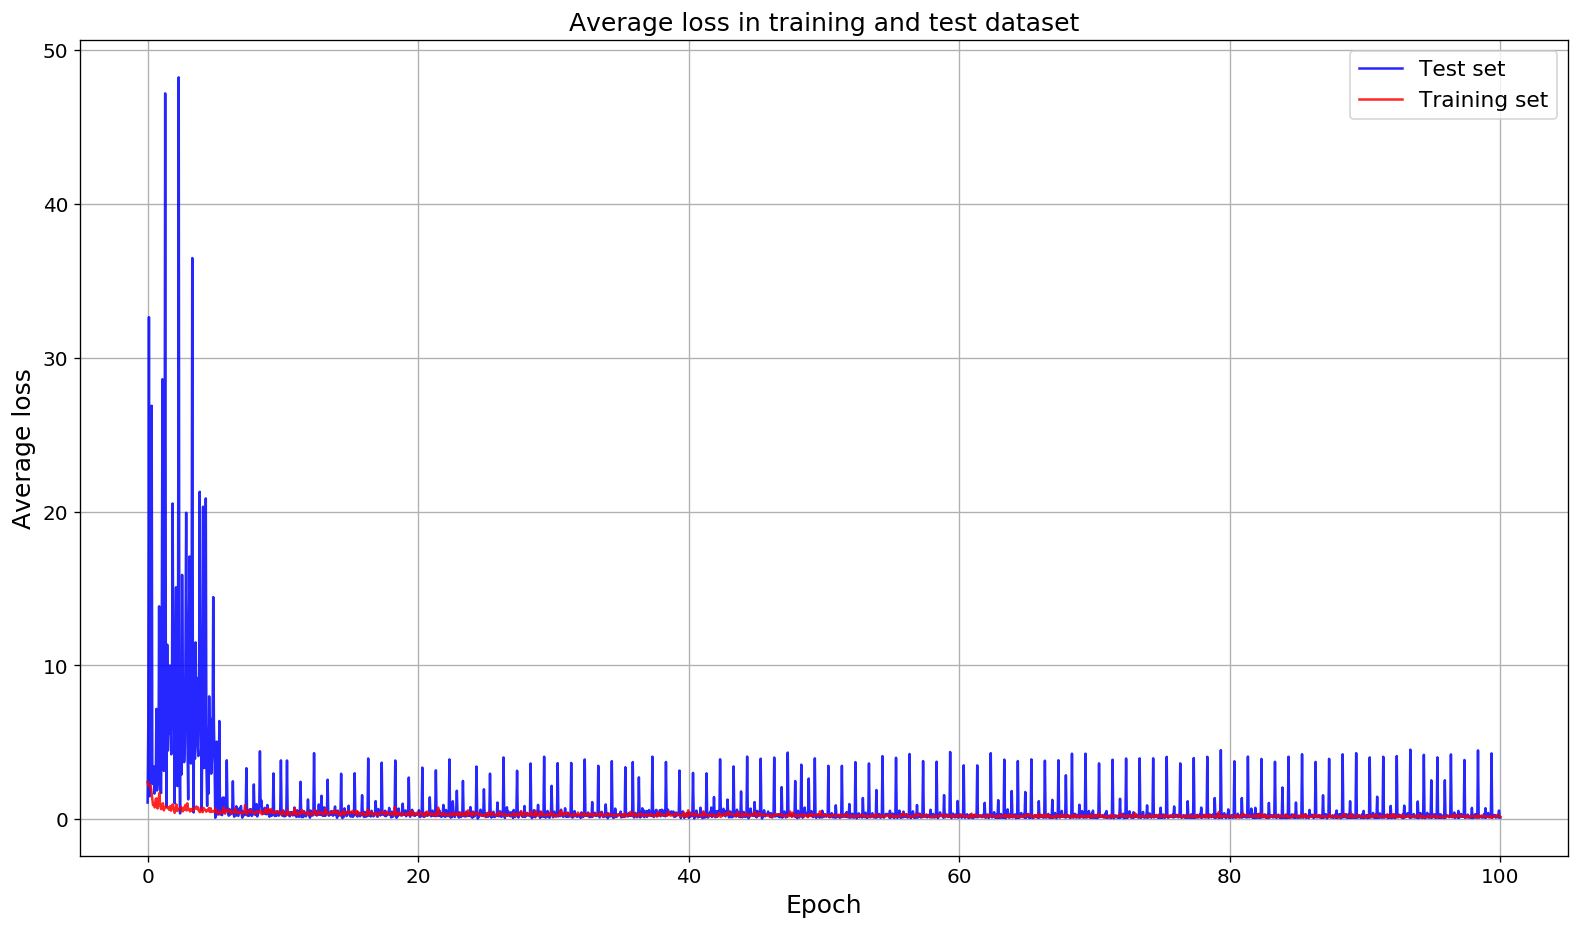

In [11]:
plt.figure(figsize = (16,9),dpi = 120)
plt.title('Average loss in training and test dataset',fontsize = 15)
plt.plot(test_x,np.array(loss_list_test),color = 'blue',alpha = 0.85,label = 'Test set')
plt.plot(train_x,np.array(loss_list_train),color = 'red',alpha = 0.85,label = 'Training set')
plt.xlabel('Epoch',fontsize = 15)
plt.ylabel('Average loss',fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 13)
plt.grid()

In [12]:
torch.save(dl.state_dict(), r'E:\UCL\Dissertation\label\trained_models\model_deeplabv3+_xception_last.pt')